# Real estate pricing

This notebook contains the analysis and the prediction of a well known real estate pricing dataset.

Before going a little deeper into the analysis, we will import the following libraries :

- pandas : upload the .csv into a pandas dataframe to make our analysis, shape our dataframe by doing some features engineering on the raw data
- pyplot from matplotlib : to display our analysis into some dataviz graphs
- hyperopt : hyperparameters tuning library
- sklearn, xgboost, lightgbm : machine learning libraries

For the definition of the features in the dataset, refer to the data_description.txt file.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

C:\Users\Dimitri Cooray\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


We load the file with the "read_csv" method from pandas.

We also set the "Id" column as the index of the dataframe since we won't use it as a feature, it will help us to identify later the rows when we'll shuffle the data.

In [2]:
df = pd.read_csv("train.csv")
df.set_index("Id", inplace=True)
pd.set_option('display.max_columns', df.shape[1])
df.shape

(1460, 80)

We have 1460 rows with 80 columns, 1 of them is the target that we want to predict, the "SalePrice".

In [3]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


By describing the dataset, we see that we have 37 columns that contains numerical values, which means that we will have to
perform some tranformations for the 43 remaining columns.

Let's display some graphs to have a better understanding about the data.

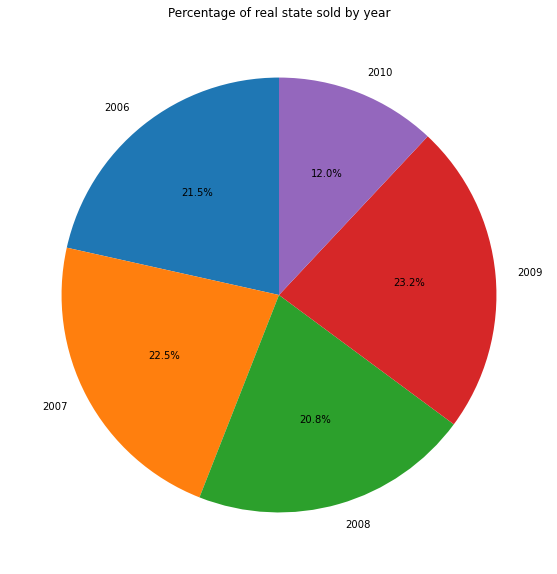

In [5]:
plt.gcf().set_size_inches(10, 10)
df_pie = df.groupby(["YrSold"])\
           .agg({"SalePrice":"count"})\
           .rename(columns={"SalePrice":"Count"})\
           .reset_index()
plt.pie(data=df_pie, x="Count", labels="YrSold", autopct='%1.1f%%', startangle=90)
plt.title("Percentage of real state sold by year")
plt.show()

We see that the distribution of the number of houses sold by year is pretty much the same between 2006 and 2009. Only 2010 has a lower percentage.

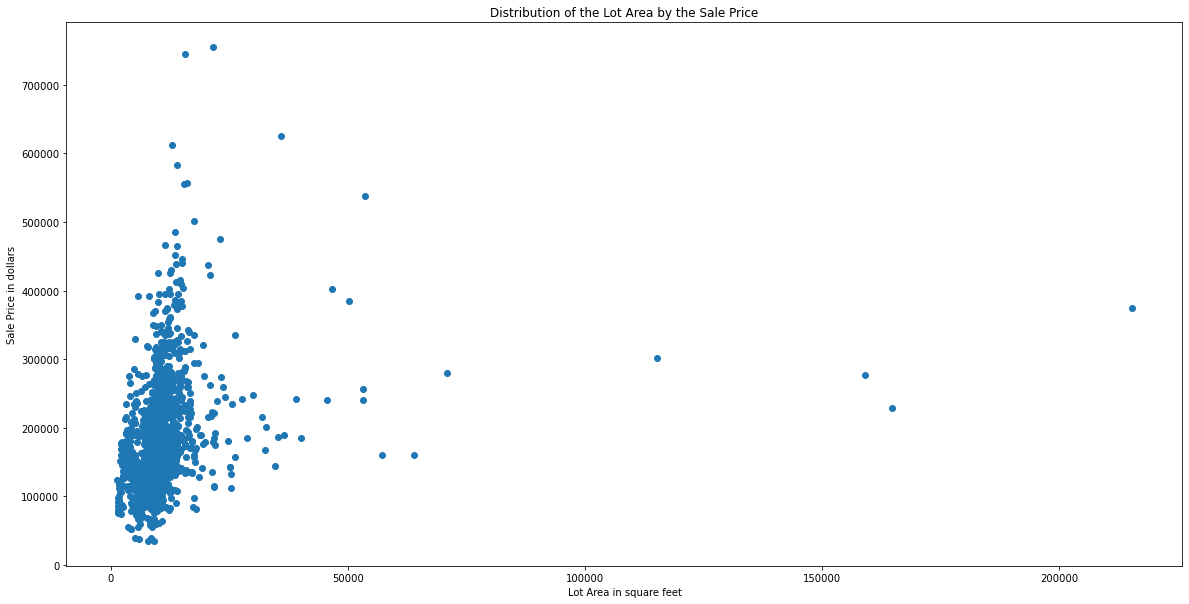

In [6]:
plt.gcf().set_size_inches(20, 10)
plt.scatter(data=df, x="LotArea", y="SalePrice")
plt.xlabel("Lot Area in square feet")
plt.ylabel("Sale Price in dollars")
plt.title("Distribution of the Lot Area by the Sale Price")
plt.show()

On this graph, we can observe that one of the major features that influence the sale price is the lot size. We almost have
a linear line that go from [0,0] to [~25000, +700000]. All the points to the right are houses that have been sold have a lower
sale price because other features brought the sale price down.

In [7]:
df[df["LotArea"] > 50000]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
54,20,RL,68.0,50271,Pave,NaN,IR1,Low,AllPub,Inside,Gtl,Veenker,Norm,Norm,1Fam,1Story,9,5,1981,1987,Gable,WdShngl,WdShing,Wd Shng,None,0.0,Gd,TA,CBlock,Ex,TA,Gd,GLQ,1810,Unf,0,32,1842,GasA,Gd,Y,SBrkr,1842,0,0,1842,2,0,0,1,0,1,Gd,5,Typ,1,Gd,Attchd,1981.0,Fin,3,894,TA,TA,Y,857,72,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal,385000
250,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1.5Fin,6,7,1958,2006,Gable,CompShg,Wd Sdng,HdBoard,BrkCmn,472.0,Gd,TA,CBlock,Gd,TA,Gd,Rec,697,Unf,0,747,1444,GasA,Gd,Y,SBrkr,1444,700,0,2144,0,1,2,0,4,1,Gd,7,Typ,2,TA,Attchd,1958.0,Fin,2,389,TA,TA,Y,0,98,0,0,0,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,Inside,Sev,Timber,Norm,Norm,1Fam,1Story,7,5,1965,1965,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,1236,Rec,820,80,2136,GasW,TA,Y,SBrkr,2036,0,0,2036,2,0,2,0,3,1,TA,8,Typ,2,Gd,Attchd,1965.0,RFn,2,513,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000
336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,Corner,Sev,Timber,Norm,Norm,2fmCon,1.5Fin,5,6,1965,1965,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Gd,ALQ,1249,BLQ,147,103,1499,GasA,Ex,Y,SBrkr,1619,167,0,1786,2,0,2,0,3,1,TA,7,Typ,2,Gd,Attchd,1965.0,Fin,2,529,TA,TA,Y,670,0,0,0,0,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
385,60,RL,NaN,53107,Pave,NaN,IR2,Low,AllPub,Corner,Mod,ClearCr,Feedr,Norm,1Fam,2Story,6,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,985,Unf,0,595,1580,GasA,Ex,Y,SBrkr,1079,874,0,1953,1,0,2,1,3,1,Gd,9,Typ,2,Fa,Attchd,1992.0,Fin,2,501,TA,TA,Y,216,231,0,0,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal,240000
452,20,RL,62.0,70761,Pave,NaN,IR1,Low,AllPub,Inside,Mod,ClearCr,Norm,Norm,1Fam,1Story,7,5,1975,1975,Gable,WdShngl,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,655,Unf,0,878,1533,GasA,TA,Y,SBrkr,1533,0,0,1533,1,0,2,0,2,1,Gd,5,Typ,2,TA,Attchd,1975.0,Unf,2,576,TA,TA,Y,200,54,0,0,0,0,NaN,NaN,NaN,0,12,2006,WD,Normal,280000
458,20,RL,NaN,53227,Pave,NaN,IR1,Low,AllPub,CulDSac,Mod,ClearCr,Norm,Norm,1Fam,1Story,4,6,1954,1994,Flat,Tar&Grv,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,Gd,BLQ,1116,Unf,0,248,1364,GasA,Ex,Y,SBrkr,1663,0,0,1663,1,0,1,0,2,1,Gd,6,Min1,2,Gd,Attchd,1954.0,Fin,2,529,TA,TA,Y,224,137,0,0,0,0,NaN,NaN,NaN,0,3,2008,WD,Normal,256000
707,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,5,1971,2002,Gable,CompShg,Plywood,Plywood,Stone,351.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,1219,Unf,0,424,1643,GasA,TA,Y,SBrkr,1824,0,0,1824,1,0,2,0,2,1,Gd,5,Typ,2,TA,Attchd,1971.0,Unf,2,739,TA,TA,Y,380,48,0,0,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal,302000
770,60,RL,47.0,53504,Pave,NaN,IR2,HLS,AllPub,CulDSac,Mod,StoneBr,Norm,Norm,1Fam,2Story,8,5,2003,2003,Hip,CompShg,CemntBd,Wd Shng,BrkFace,603.0,Ex,TA,PConc,Gd,TA,Gd,ALQ,1416,Unf,0,234,1650,GasA,Ex,Y,SBrkr,1690,1589,0,3279,1,0,3,1,4,1,Ex,12,Mod,1,Gd,BuiltIn,2003.0,Fin,3,841,TA,TA,Y,503,36,0,0,210,0,NaN,NaN,NaN,0,6,2010,WD,Normal,538000


When we have a look to the houses that has a lot area over 50000 square feet, we can see that the majority belongs to two
neighborhoods, "Timber" and "ClearCr".

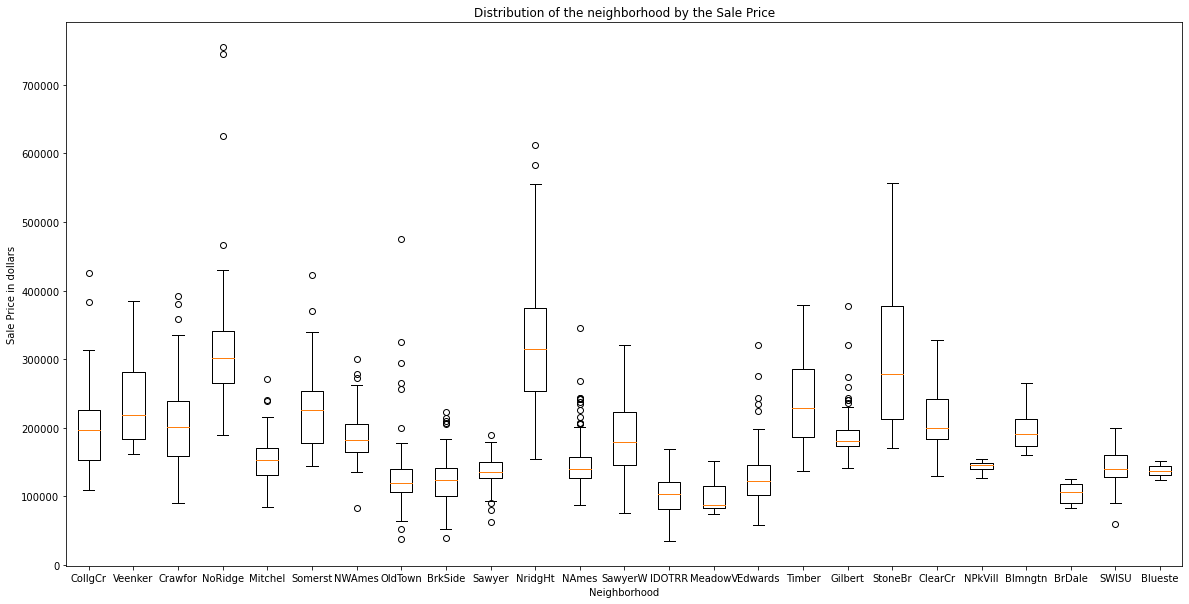

In [8]:
def create_data_lists(names, col_n) :
    
    """
    Create a new dataframe for the all the boxplots.
    """
    
    values_ret = []
    name_list = []
    for name in names :
        values_ret.append(df[df[col_n] == name]["SalePrice"].tolist())
        name_list.append(name)
    return values_ret, name_list

col_name = "Neighborhood"
nh_val, nh_name = create_data_lists(df[col_name].unique().tolist(), col_name)
plt.gcf().set_size_inches(20, 10)
plt.boxplot(nh_val, labels=nh_name)
plt.xlabel("Neighborhood")
plt.ylabel("Sale Price in dollars")
plt.title("Distribution of the neighborhood by the Sale Price")
plt.show()

"Timber" and "ClearCr" are indeed in the mid range of the sale price. We also have 3 neighborhoods that stand out of the pack :
"NoRidge", NridgHt" and "StoneBr". They seem to be the wealthiest neighborhoods.

In [9]:
df[df["SalePrice"] > 500000]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
179,20,RL,63.0,17423,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,StoneBr,Norm,Norm,1Fam,1Story,9,5,2008,2009,Hip,CompShg,VinylSd,VinylSd,Stone,748.0,Ex,TA,PConc,Ex,TA,No,GLQ,1904,Unf,0,312,2216,GasA,Ex,Y,SBrkr,2234,0,0,2234,1,0,2,0,1,1,Ex,9,Typ,1,Gd,Attchd,2009.0,Fin,3,1166,TA,TA,Y,0,60,0,0,0,0,NaN,NaN,NaN,0,7,2009,New,Partial,501837
441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2008,2008,Hip,CompShg,VinylSd,VinylSd,Stone,200.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1767,ALQ,539,788,3094,GasA,Ex,Y,SBrkr,2402,0,0,2402,1,0,2,0,2,1,Ex,10,Typ,2,Gd,Attchd,2008.0,Fin,3,672,TA,TA,Y,0,72,0,0,170,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000
692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
770,60,RL,47.0,53504,Pave,NaN,IR2,HLS,AllPub,CulDSac,Mod,StoneBr,Norm,Norm,1Fam,2Story,8,5,2003,2003,Hip,CompShg,CemntBd,Wd Shng,BrkFace,603.0,Ex,TA,PConc,Gd,TA,Gd,ALQ,1416,Unf,0,234,1650,GasA,Ex,Y,SBrkr,1690,1589,0,3279,1,0,3,1,4,1,Ex,12,Mod,1,Gd,BuiltIn,2003.0,Fin,3,841,TA,TA,Y,503,36,0,0,210,0,NaN,NaN,NaN,0,6,2010,WD,Normal,538000
804,60,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2008,2009,Hip,CompShg,VinylSd,VinylSd,Stone,424.0,Ex,TA,PConc,Ex,TA,Gd,Unf,0,Unf,0,1734,1734,GasA,Ex,Y,SBrkr,1734,1088,0,2822,0,0,3,1,4,1,Ex,12,Typ,1,Gd,BuiltIn,2009.0,RFn,3,1020,TA,TA,Y,52,170,0,0,192,0,NaN,NaN,NaN,0,1,2009,New,Partial,582933
899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2009,2010,Hip,CompShg,VinylSd,VinylSd,Stone,760.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2188,Unf,0,142,2330,GasA,Ex,Y,SBrkr,2364,0,0,2364,1,0,2,1,2,1,Ex,11,Typ,2,Gd,Attchd,2009.0,Fin,3,820,TA,TA,Y,0,67,0,0,0,0,NaN,NaN,NaN,0,3,2010,New,Partial,611657
1047,60,RL,85.0,16056,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,1Fam,2Story,9,5,2005,2006,Hip,CompShg,CemntBd,CmentBd,Stone,208.0,Gd,TA,PConc,Ex,TA,Av,GLQ,240,Unf,0,1752,1992,GasA,Ex,Y,SBrkr,1992,876,0,2868,0,0,3,1,4,1,Ex,11,Typ,1,Gd,BuiltIn,2005.0,Fin,3,716,TA,TA,Y,214,108,0,0,0,0,NaN,NaN,NaN,0,7,2006,New,Partial,556581
1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1995,1996,Hip,CompShg,HdBoard,HdBoard,BrkFace,1378.0,Gd,Gd,PConc,Ex,TA,Gd,GLQ,1387,Unf,0,543,1930,GasA,Ex,Y,SBrkr,1831,1796,0,3627,1,0,3,1,4,1,Gd,10,Typ,1,TA,Attchd,1995.0,Fin,3,807,TA,TA,Y,361,76,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000
1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000


The previous insight is confirmed with this dataframe that contains the houses that have been sold for over 500k dollars.
All the houses in this list belongs to these three neighborhoods.

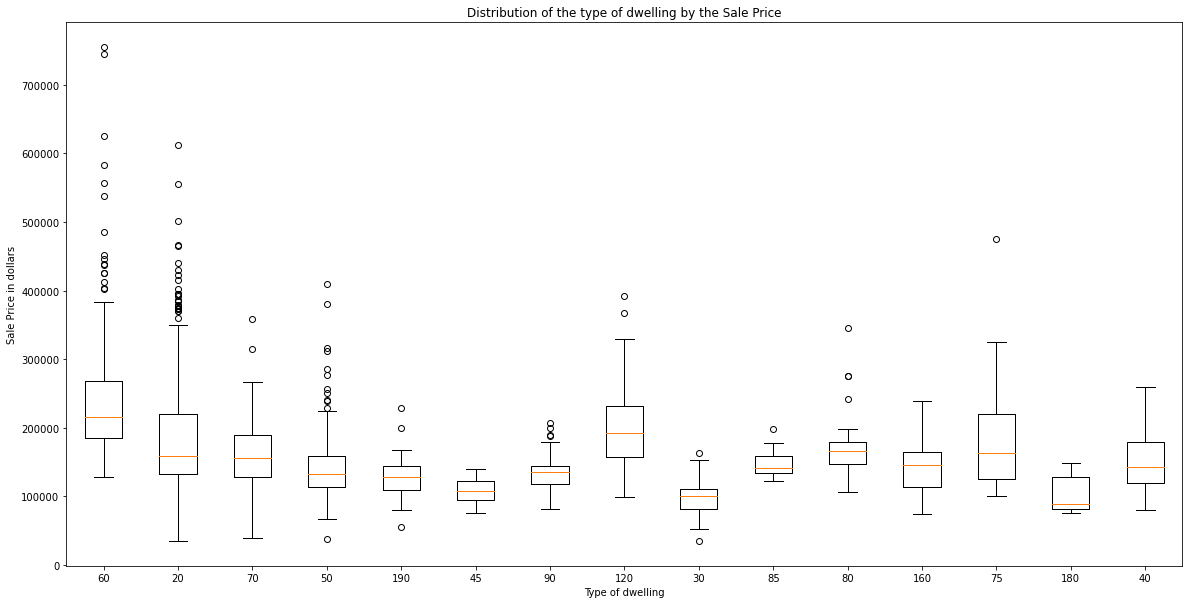

In [10]:
col_name = "MSSubClass"
ms_val, ms_name = create_data_lists(df[col_name].unique().tolist(), col_name)
plt.gcf().set_size_inches(20, 10)
plt.boxplot(ms_val, labels=ms_name)
plt.xlabel("Type of dwelling")
plt.ylabel("Sale Price in dollars")
plt.title("Distribution of the type of dwelling by the Sale Price")
plt.show()

In this plot, we can see that houses with a second floor ("60", "75") and that are built after 1946 ("60", "120", "20").
In opposition, the houses that are built before 1945 and only have one floor ("30") tend to sold for much cheaper.

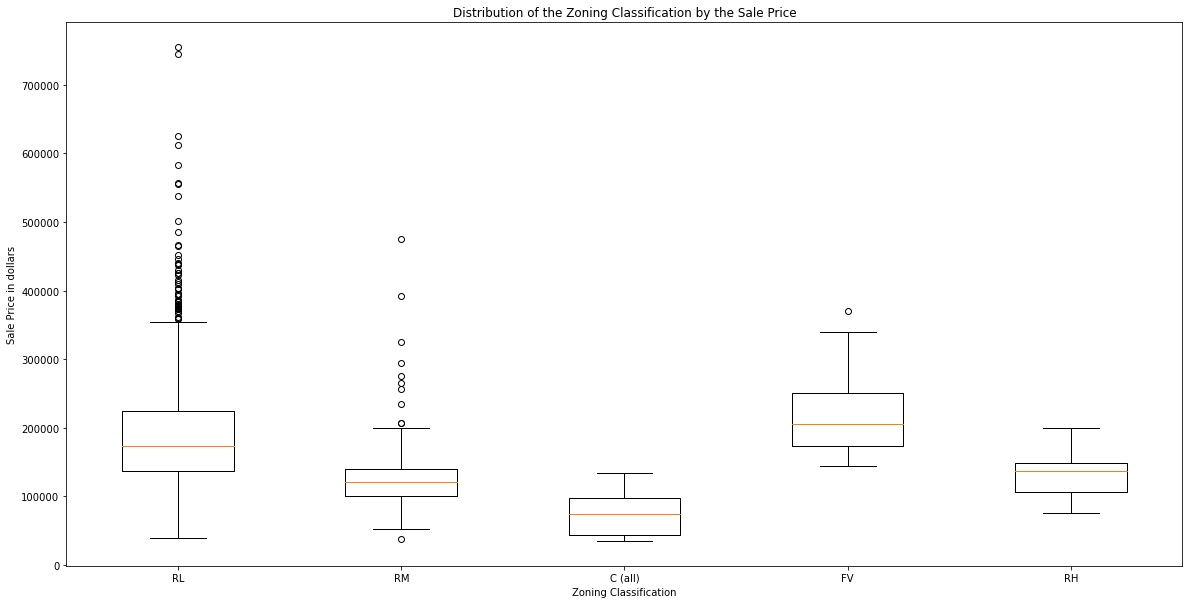

In [11]:
col_name = "MSZoning"
ms_val, ms_name = create_data_lists(df[col_name].unique().tolist(), col_name)
plt.gcf().set_size_inches(20, 10)
plt.boxplot(ms_val, labels=ms_name)
plt.xlabel("Zoning Classification")
plt.ylabel("Sale Price in dollars")
plt.title("Distribution of the Zoning Classification by the Sale Price")
plt.show()

This plot is very interesting because the "RL" (Residential Low Density) has a huge range when it comes to its distribution.
A lot of neighborhoods have this configuration which explains why we have some of the lowest sale price but also the highest.
The "FV" (Floating Village Residential) in general costs way more than the others configurations since these places are
situated in the richest neighborhoods. "C" (Commercial) have the lowest sale price since nobody wants to live near a mall or
other crowded zones.

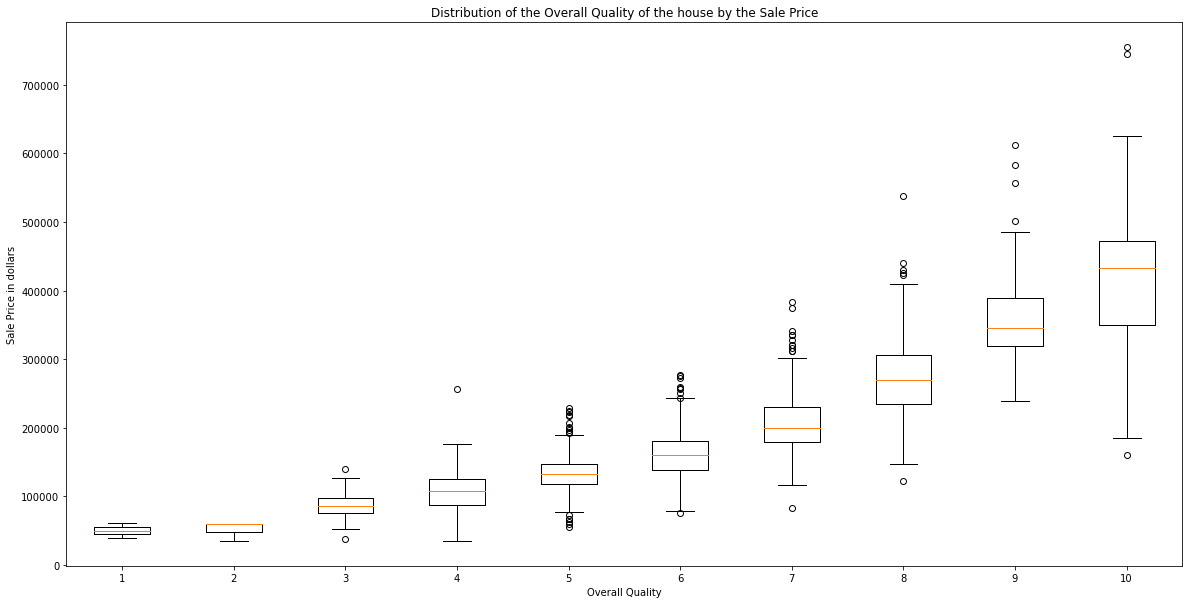

In [12]:
def rearange_ovr_data(data, number_list) :
    
    """
    Rearange the data to have the boxplot in an ascending sort.
    """
    
    ret_data = []
    ret_number = list(range(1, len(number_list) + 1))
    for i in ret_number :
        for j, val in enumerate(number_list) :
            if i == val :
                ret_data.append(data[j])
    return ret_data, ret_number


col_name = "OverallQual"
ms_val, ms_name = create_data_lists(df[col_name].unique().tolist(), col_name)
ms_val, ms_name = rearange_ovr_data(ms_val, ms_name)
plt.gcf().set_size_inches(20, 10)
plt.boxplot(ms_val, labels=ms_name)
plt.xlabel("Overall Quality")
plt.ylabel("Sale Price in dollars")
plt.title("Distribution of the Overall Quality of the house by the Sale Price")
plt.show()

This plot shows us the linearity correlation that exists between the quality of the house (material used, finish of the house).

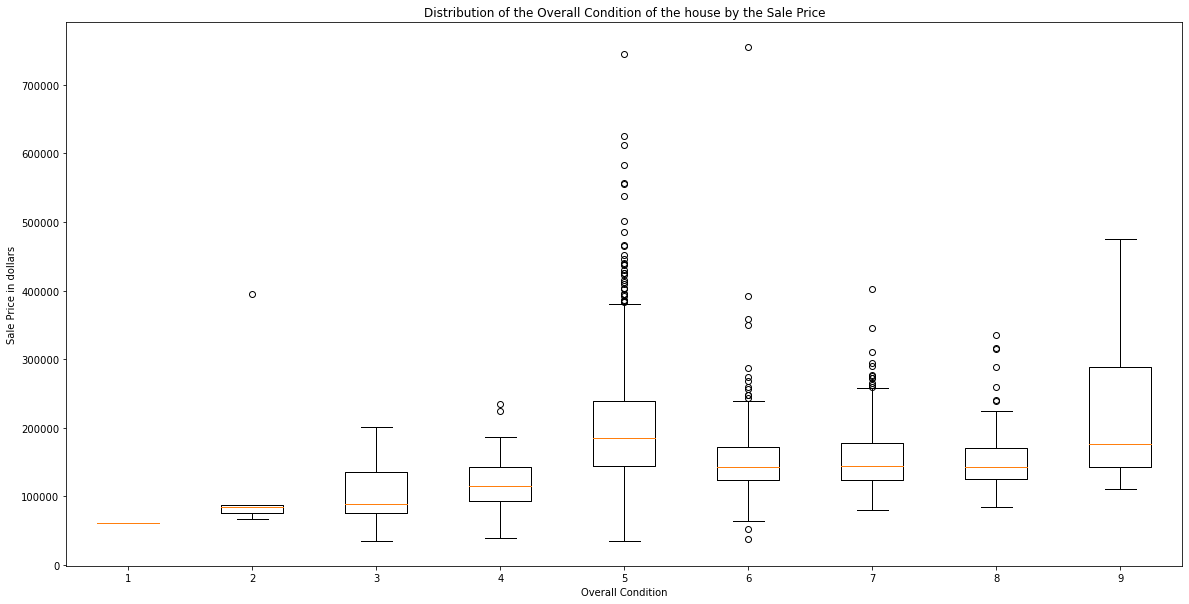

In [13]:
col_name = "OverallCond"
ms_val, ms_name = create_data_lists(df[col_name].unique().tolist(), col_name)
ms_val, ms_name = rearange_ovr_data(ms_val, ms_name)
plt.gcf().set_size_inches(20, 10)
plt.boxplot(ms_val, labels=ms_name)
plt.xlabel("Overall Condition")
plt.ylabel("Sale Price in dollars")
plt.title("Distribution of the Overall Condition of the house by the Sale Price")
plt.show()

In contrary, the condition doesn't matter that much since people tend to make some renovations of the houses they buy. Which
explains why the majority of the houses bought have an average condition.

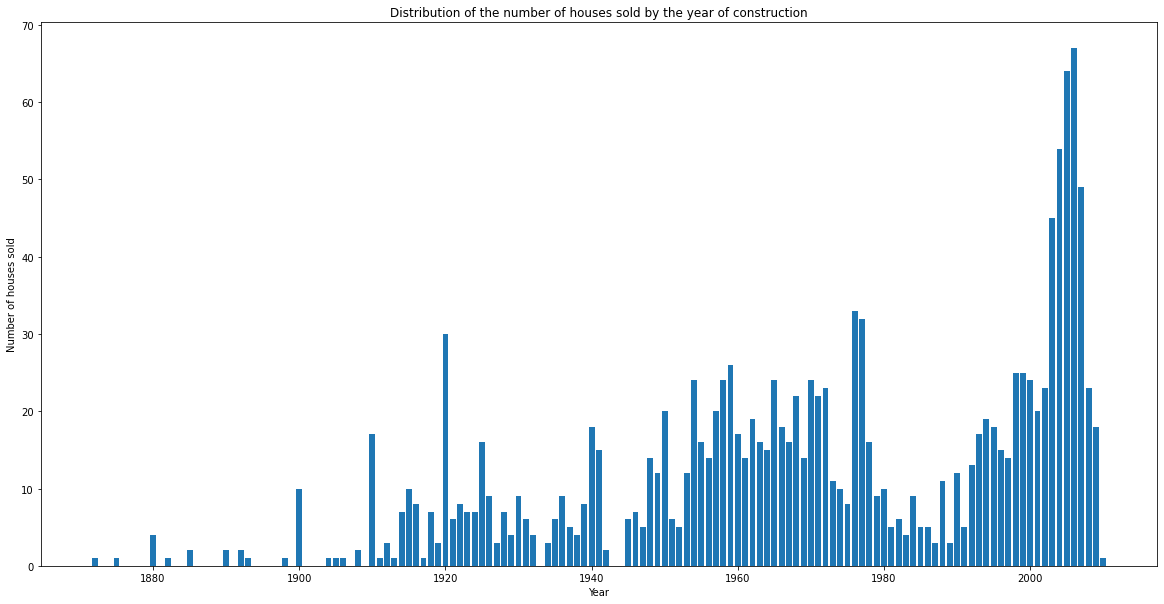

In [14]:
plt.gcf().set_size_inches(20, 10)
df_year_built = df.groupby(["YearBuilt"])\
                  .agg({"SalePrice":"count"})\
                  .rename(columns={"SalePrice":"Count"})\
                  .reset_index()
plt.bar(data=df_year_built, x="YearBuilt", height="Count")
plt.xlabel("Year")
plt.ylabel("Number of houses sold")
plt.title("Distribution of the number of houses sold by the year of construction")
plt.show()

We have a representation of the distribution of the house. It goes to show that people are more interested in buying a house
that have been recently built.

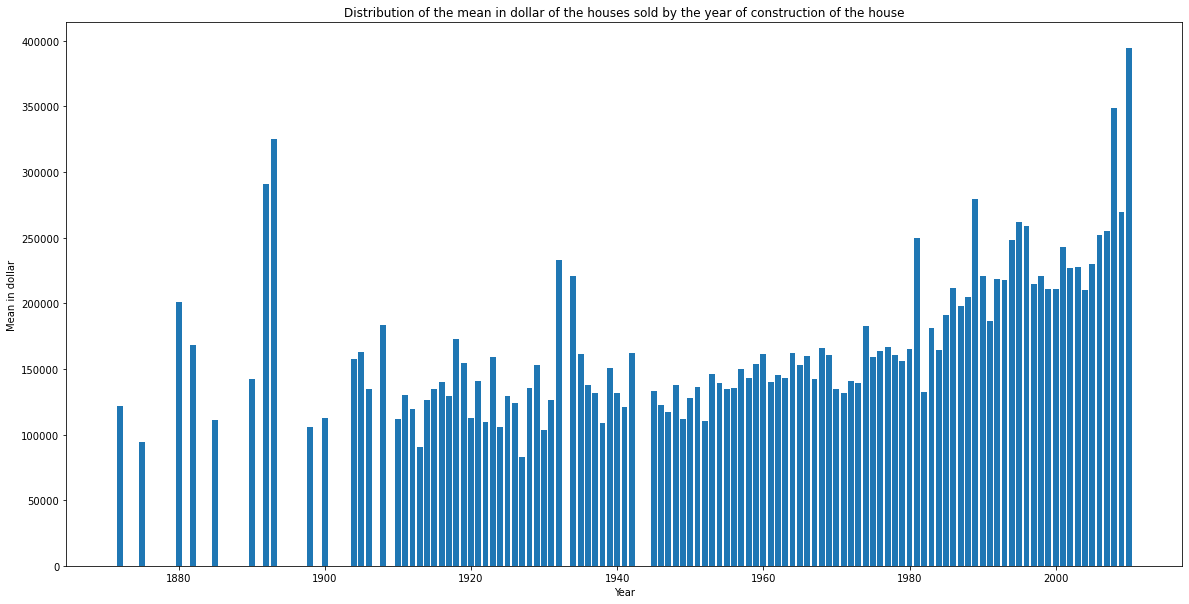

In [15]:
plt.gcf().set_size_inches(20, 10)
df_year_built = df.groupby(["YearBuilt"])\
                  .agg({"SalePrice":"mean"})\
                  .rename(columns={"SalePrice":"Mean"})\
                  .reset_index()
plt.bar(data=df_year_built, x="YearBuilt", height="Mean")
plt.xlabel("Year")
plt.ylabel("Mean in dollar")
plt.title("Distribution of the mean in dollar of the houses sold by the year of construction of the house")
plt.show()

We have a linear correlation here with a few houses sold before 1945 that sold much higher than what we expected. This can be
explained a few features (nighborhood, year of renovation, ...). After 1945, we have a clear view that newer houses sell
higher than the older ones.

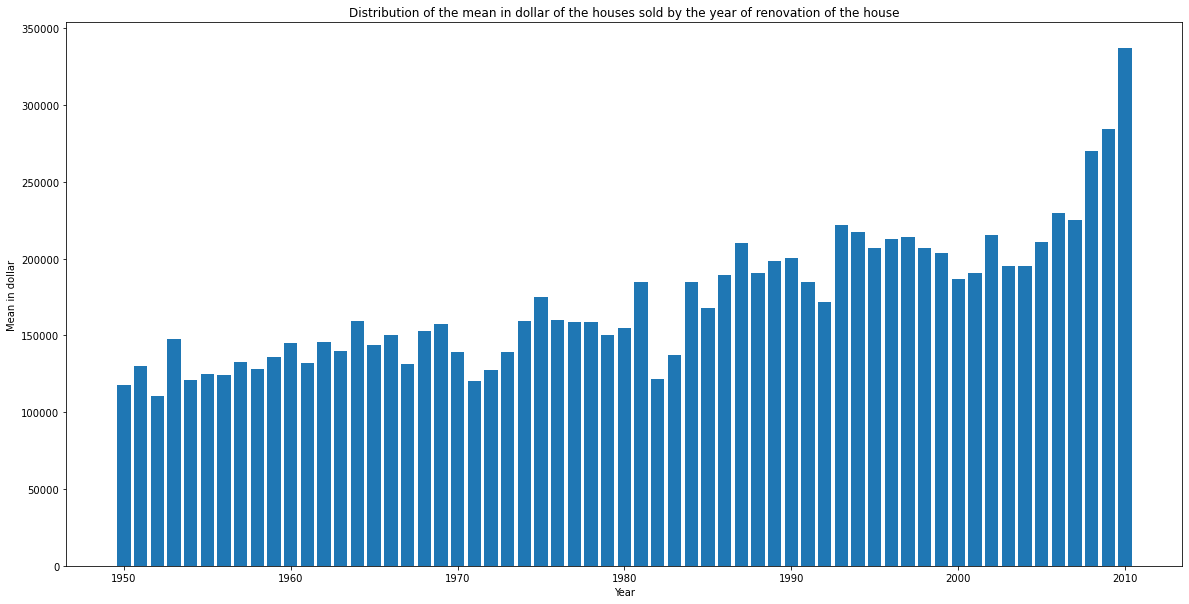

In [16]:
plt.gcf().set_size_inches(20, 10)
df_year_remod = df.groupby(["YearRemodAdd"])\
                  .agg({"SalePrice":"mean"})\
                  .rename(columns={"SalePrice":"Mean"})\
                  .reset_index()
plt.bar(data=df_year_remod, x="YearRemodAdd", height="Mean")
plt.xlabel("Year")
plt.ylabel("Mean in dollar")
plt.title("Distribution of the mean in dollar of the houses sold by the year of renovation of the house")
plt.show()

This plot shows the linear correlation that houses that have been renovated recently tend to sell for a higher sale price than the older ones.

In [17]:
def create_df_pred(dummies_names, data) :
    
    """
    Join all the dummies created to the model dataframe.
    """
    
    df_ret = pd.DataFrame()
    for name in dummies_names :
        if df_ret.empty :
            df_ret = pd.get_dummies(data[name], prefix=name)
        else :
            df_ret = df_ret.join(pd.get_dummies(data[name], prefix=name))
    return df_ret

def join_numerical_values(numerical_list, data, original_data) :
    
    """
    Join all the numerical values to the model dataframe.
    """
    
    for num_name in numerical_list :
        data.insert(data.shape[1], num_name, original_data[num_name])
    return data


dummies_list = ["MSSubClass",
                "MSZoning",
                "Street",
                "LotShape",
                "LandContour",
                "Utilities",
                "LotConfig",
                "LandSlope",
                "Neighborhood",
                "Alley",
                "Condition1",
                "Condition2",
                "BldgType",
                "HouseStyle",
                "OverallCond",
                "RoofStyle",
                "RoofMatl",
                "Exterior1st",
                "Exterior2nd",
                "ExterQual",
                "ExterCond",
                "BsmtExposure",
                "BsmtFinType1",
                "BsmtFinType2",
                "Heating",
                "HeatingQC",
                "CentralAir",
                "Electrical",
                "KitchenQual",
                "Functional",
                "FireplaceQu",
                "GarageType",
                "GarageFinish",
                "GarageQual",
                "GarageCond",
                "PavedDrive",
                "PoolQC",
                "Fence",
                "MiscFeature",
                "MoSold",
                "YrSold",
                "SaleType",
                "SaleCondition"]

num_list = ["LotFrontage",
            "LotArea",
            "OverallQual",
            "YearBuilt",
            "YearRemodAdd",
            "MasVnrArea",
            "BsmtFinSF1",
            "BsmtFinSF2",
            "BsmtUnfSF",
            "1stFlrSF",
            "2ndFlrSF",
            "LowQualFinSF",
            "BsmtFullBath",
            "BsmtHalfBath",
            "FullBath",
            "HalfBath",
            "BedroomAbvGr",
            "KitchenAbvGr",
            "TotRmsAbvGrd",
            "Fireplaces",
            "GarageYrBlt",
            "GarageCars",
            "GarageArea",
            "WoodDeckSF",
            "OpenPorchSF",
            "EnclosedPorch",
            "3SsnPorch",
            "ScreenPorch",
            "PoolArea",
            "MiscVal",
            "SalePrice"]

df_replace_nan = df.replace({"MasVnrType":"None"}, np.nan)
df_pred = create_df_pred(dummies_list, df_replace_nan)
df_pred = join_numerical_values(num_list, df_pred, df)
df_pred.rename(columns={"MSZoning_C (all)":"MSZoning_C"}, inplace=True)
df_pred.fillna(0, inplace=True)

With this cell, we create the dataframe with all the dummies and numerical values that can be exploited by the models. We also
fill all the "NaN" values by 0.

In [18]:
def training_regressor(X_data, y_target, reg_list) :
    
    """
    List a few metrics to compare a bunch of regressor models.
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.4,
                                                        random_state=42)
    result = {"Model":[], "Adjusted R-Squared":[], "R-Squared":[], "RMSE":[]}
    for reg in reg_list :
        if "XGBRegressor" in str(reg) :
            result["Model"].append("XGBRegressor")
        else :
            result["Model"].append(str(reg)[:-2])
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        n = X_train.shape[0]
        p = X_train.shape[1]
        result["Adjusted R-Squared"].append(1 - (1 - r2) * ((n - 1) / (n - p - 1)))
        result["R-Squared"].append(r2)
        result["RMSE"].append(np.sqrt(mean_squared_error(y_test, y_pred)))
    return pd.DataFrame(result)\
             .sort_values(["Adjusted R-Squared", "R-Squared"], ascending=False)
        

regressor_list = [SVR(),
                  BaggingRegressor(),
                  RandomForestRegressor(),
                  XGBRegressor(),
                  GradientBoostingRegressor(),
                  AdaBoostRegressor(),
                  LGBMRegressor(),
                  KNeighborsRegressor(),
                  DecisionTreeRegressor(),
                  LinearRegression()]

X = df_pred.drop(columns="SalePrice")
y = df_pred["SalePrice"]
training_regressor(X, y, regressor_list)

C:\Users\Dimitri Cooray\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,Model,Adjusted R-Squared,R-Squared,RMSE
3,XGBRegressor,0.811586,0.877261,29825.523911
4,GradientBoostingRegressor,0.801534,0.870713,30610.792055
9,LinearRegression,0.801495,0.870688,30613.773055
6,LGBMRegressor,0.798629,0.868821,30833.952834
1,BaggingRegressor,0.792358,0.864736,31310.434435
2,RandomForestRegressor,0.776268,0.854255,32500.849071
5,AdaBoostRegressor,0.701870,0.805790,37517.494880
8,DecisionTreeRegressor,0.555717,0.710581,45799.517030
7,KNeighborsRegressor,0.410222,0.615802,52768.569760
0,SVR,-0.599521,-0.041973,86901.230492


Now that we have everything, we can train some models and see the impact and see the impact they have on a test set. There are three regressor models that stand out everytime we run this cell : "XGBRegressor", "GradientBoostingRegressor" and "LinearRegression". We have a few metrics that we use to compare these models : "R-Squared" which tells us how much variance has been explained by the model, "Ajusted R-Squared" has the same properties than "R-Squared" but focuses on the features that really have an impact on the model. So when we work with multivariate linear regression, it's better to focus on "Adjusted R-Squared" than the other one. "RMSE" (root mean squared error) is the last metric that we use to compare the performances of the
models. It shows how far predictions fall from measured true values using Euclidean distance.

In [19]:
def objective(params):
    
    """
    Minimize a metric (in this case the mean squared error) to find the best hyperparameters.
    """
    
    regressor_type = params["type"]
    del params["type"]
    if regressor_type == "xgb":
        reg = XGBRegressor(**params)
    elif regressor_type == "gbr":
        reg = GradientBoostingRegressor(**params)
    else:
        return 0
    accuracy = cross_val_score(reg,
                               X,
                               y,
                               cv=10,
                               n_jobs=-1,
                               scoring="neg_mean_squared_error").mean()
    
    # Because fmin() tries to minimize the objective, this function must return the negative accuracy. 
    return {"loss": -accuracy, "status": STATUS_OK}

We will use Hyperopt to find the best hyperparameters possible to minimize the MSE (mean squared error). We create the spaces with all the parameters we want to test then we pass it to the "fmin" method of Hyperopt that will minimize our metric using
our "objective" function.

In [20]:
search_space_xgb = {"type":"xgb",
                    "eta":hp.lognormal("eta", 0, 1),
                    "max_depth":scope.int(hp.quniform("max_depth", 0, 50, 1)),
                    "n_estimators":scope.int(hp.quniform("n_estimators", 50, 500, 10)),
                    "colsample_bytree":hp.uniform("colsample_bytree", 0.01, 1),
                    "colsample_bylevel":hp.uniform("colsample_bylevel", 0.01, 1),
                    "colsample_bynode":hp.uniform("colsample_bynode", 0.01, 1),
                    "subsample":hp.uniform("subsample", 0.01, 1)}

best_result_xgb = fmin(objective,
                       space=search_space_xgb,
                       algo=tpe.suggest,
                       max_evals=100,
                       trials=Trials())

100%|██████████| 100/100 [07:04<00:00,  4.25s/trial, best loss: 732092983.0384295]


Hyperparameters tuning for XGBRegressor.

In [21]:
search_space_gbr = {"type":"gbr",
                    "learning_rate":hp.uniform("learning_rate", 0, 2),
                    "max_depth":scope.int(hp.quniform("max_depth", 1, 25, 1)),
                    "n_estimators":scope.int(hp.quniform("n_estimators", 80, 120, 10)),
                    "min_samples_split":scope.int(hp.uniform("min_samples_split", 2, 8)),
                    "min_samples_leaf":scope.int(hp.uniform("min_samples_leaf", 1, 5)),
                    "min_weight_fraction_leaf":hp.uniform("min_weight_fraction_leaf", 0, 0.2),
                    "subsample":hp.uniform("subsample", 0.8, 1)}

best_result_gbr = fmin(objective,
                       space=search_space_gbr,
                       algo=tpe.suggest,
                       max_evals=500,
                       trials=Trials())

100%|██████████| 500/500 [09:04<00:00,  1.09s/trial, best loss: 776314179.8803416]


Hyperparameters tuning for GradientBoostingRegressor.

In [22]:
def training_best_regressor(X_data, y_target, reg_list) :
    
    """
    List the three best regressor models that we got with the previous comparison
    """

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.4,
                                                        random_state=42)
    result = {"Model":[], "Adjusted R-Squared":[], "R-Squared":[], "RMSE":[]}
    for reg in reg_list :
        if "XGBRegressor" in str(reg) :
            reg_name = "XGBRegressor"
        elif "GradientBoosting" in str(reg) :
            reg_name = "GradientBoostingRegressor"
        else :
            reg_name = str(reg)[:-2]
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        n = X_train.shape[0]
        p = X_train.shape[1]
        result["Model"].append(reg_name)
        result["Adjusted R-Squared"].append(1 - (1 - r2) * ((n - 1) / (n - p - 1)))
        result["R-Squared"].append(r2)
        result["RMSE"].append(np.sqrt(mean_squared_error(y_test, y_pred)))
    return pd.DataFrame(result)\
             .sort_values(["Adjusted R-Squared", "R-Squared"], ascending=False)

xgb_params = space_eval(search_space_xgb, best_result_xgb)
gbr_params = space_eval(search_space_gbr, best_result_gbr)
del xgb_params["type"]
del gbr_params["type"]
best_regressor_list = [XGBRegressor(**xgb_params),
                       GradientBoostingRegressor(**gbr_params),
                       LinearRegression()]
training_best_regressor(X, y, best_regressor_list)

C:\Users\Dimitri Cooray\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,Model,Adjusted R-Squared,R-Squared,RMSE
0,XGBRegressor,0.832483,0.890875,28122.932931
1,GradientBoostingRegressor,0.809228,0.875726,30011.543404
2,LinearRegression,0.801495,0.870688,30613.773055


We rerun our function that is a little bit modified which will take into account the tuning of the hyperparameters.
We see that compared to the previous spreadsheet, the performance of the "XGBRegressor" model increased and the "GradientBoostingRegressor" model also increased by a little. Which means that the default setup for the "GradientBoosting" model was on point. For this use case, the best model we can use is the "XGBRegressor" model.